# 0. Once again eigenphase

Find eigenstates and eigenphases of $H$.

In [4]:
import numpy as np
from numpy.linalg import eig

H = np.array([[1, 1], [1, -1]]) * (.5 ** .5)

evals, evecs = eig(H)
for va, ve in zip(evals, evecs.T):
    print(f"{va:.4f} {ve}")

1.0000 [0.92387953 0.38268343]
-1.0000 [-0.38268343  0.92387953]


## Prepare these eigenstates with rotations

Find a single rotation gate, which prepares an eigenstate. For each of them.

In [15]:
from math import acos, pi
from fractions import Fraction

# TODO your code here
# find a fraction of PI
frac = ... / pi

fr = Fraction(frac).limit_denominator(64)
print(f"{fr} * π")

5/4 * π


## Experience phase kickback

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import HGate
import matplotlib.pyplot as plt

qc = QuantumCircuit(2)

qc.h(1)
qc.barrier()

# TODO: YOUR ROTATION GATE HERE
qc.r... #

qc.append(HGate().control(1), [1, 0])

qc.barrier()
qc.h(1)
print(qc.draw())

np.asarray(
    execute(qc, Aer.get_backend('statevector_simulator')).result().get_statevector()
).real

## How multiple applications of $U$ affect the phase?

$Uv=\lambda v$.

$U^kv=\lambda^kv = (e^{i\phi})^kv=e^{ik\phi}v$.

It rotates the state vector $v$ (obviously) $k$ times by angle $\phi$ around $Z$.

## Eigenphase esitimation
As unitary matrix eigenvalues always have a norm of 1, their arguments (phases) are the only essential values. That is why we call them "eigenphases".

Given a unitary matrix $U$ and an eigenstate $v$, find an eigenphase (eigenvalue) $e$:

$Uv = \lambda v$

The task itself is simple, 

$\lambda = e^{i\phi} = \frac{Uv}{v}$,

but using quantum parallelism we can **perform this operation with a superposition of eigenstates**, getting the superposition of eigenphases.

### Circuit input:
1. Quantum register of the matrix dimension, which stores the eigenvector (eigenstate).
2. Quantum register (output) of `m`-qubits prepared in $|0
\rangle^{\otimes m}$, which will be responsible for the result with accuracy or `m`. Expected output is $|out\rangle=\frac{\theta}{2\pi}\times 2^m$. I.e. with 4 qubits and $\phi=\pi$ we would expect the circuit to return $|2^{m-1}\rangle=|1000\rangle$. For non-integers probability will "blur" among neighbour states.
3. Implementation of $CU$.

We will start with preparing eigenstate in `vec` and equal superposition of all states in `result`.

$|result\rangle=\frac{1}{2^{m/2}}(|0\rangle+|1\rangle)^{\otimes m}$

In [ ]:
qvec = QuantumRegister(1, name="vec")  # eigenvector of H
qres = QuantumRegister(4, name="result")  # result register
cres = ClassicalRegister(4, name="cr") # binary result
qc = QuantumCircuit(qvec, qres, cres)

# TODO prepare eigenstate of H with a rotation gate
qc.ry(frac * pi, qvec)

# equal superposition
qc.h(qres)
qc.barrier()

qc.draw()

## Conditional phase rotations (kickbacks)

We will allow our operator $H$ kickback once into the 0-th result qubit.



In [ ]:
qc.append(HGate().control(1), [qres[0], qvec[0]])
qc.draw()

What do we have now in `result`?

$|result\rangle = \frac{1}{2^{m/2}}(|0\rangle+e^{i\phi}|1\rangle)\otimes(|0\rangle+|1\rangle)^{\otimes m-1}$

We will allow our operator $H$ kickback twice into the 1-st result qubit.

In [ ]:
qc.append(HGate().control(1), [qres[1], qvec[0]])
qc.append(HGate().control(1), [qres[1], qvec[0]])
qc.draw()

What do we have now in `result`?

$|result\rangle = \frac{1}{2^{m/2}}(|0\rangle+e^{i\phi}|1\rangle)\otimes(|0\rangle+e^{2i\phi}|1\rangle)\otimes(|0\rangle+|1\rangle)^{\otimes m-2}$

What if we proceed with $2^2$ times to 2-nd qubit and $2^3$ to 3-rd qubit?

$|result\rangle = \frac{1}{2^{m/2}}\bigotimes_{k=0}^{m-1}(|0\rangle+e^{i2^k\phi}|1\rangle)$

- Where did we see this? 
  - In QFT! 
- What did it mean? 
  - Frequency components encoded into phases! There $\phi=\frac{1}{2^m\pi}$
- What will happen, if we do IQFT?
  - Given frequencies we will obtain closest binary number (or their superposition)!

In [ ]:
# TODO: COMPLETE THE CODE for 2nd and 3rd controlling qubits


# Here we run QFT and measure
from qiskit.circuit.library import QFT

qc.append(QFT(4).inverse(), qres)
qc.measure(qres, cres)

qc.draw()

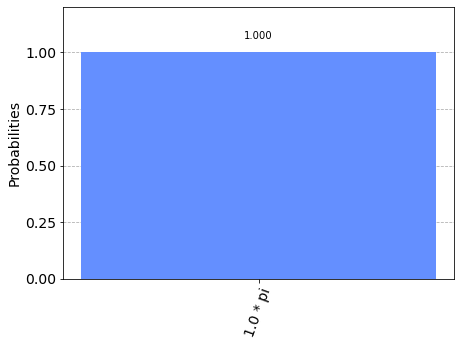

In [23]:
shots = 5000
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(qc)

plot_histogram(dict((f"{int(k, base=2) * 2 / 2 ** 4} * pi", v) for (k, v) in counts.items()))